In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import json
import glob
import itertools
from PIL import Image
import pandas as pd

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# prompt: load in files from google drive

from google.colab import drive
drive.mount('/content/drive')
#Example to load a csv
#df = pd.read_csv('/content/drive/My Drive/your_file.csv')
#print(df.head())


Mounted at /content/drive


In [ ]:
#load in files from gcloud
rna_data = pd.read_csv('/content/drive/My Drive/ML4FGSTABMAP/cleaned_RNA.csv')
colData = pd.read_csv('/content/drive/My Drive/ML4FGSTABMAP/cleaned_colData.csv')
MultiomeData = pd.read_csv('/content/drive/My Drive/ML4FGSTABMAP/cleaned_Multiome.csv')


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/ML4FGSTABMAP/cleaned_RNA.csv'

In [2]:


class BioDataset(torch.utils.data.Dataset):
    def __init__(self, rna_path, mult_path, cell_type_path, is_train):
        self.rna = []
        self.shared = []
        self.mult = []
        self.cell_type = []

        atac_data = pd.read_csv(rna_path, index_col=0)
        mult_data = pd.read_csv(mult_path, index_col=0)
        cell_type = pd.read_csv(cell_type_path, index_col=0)


        # Transpose atac and mult
        atac_data = atac_data.T
        mult_data = mult_data.T

        # Drop the first row
        atac_data = atac_data.iloc[1:]
        mult_data = mult_data.iloc[1:]

        # Join cell_type's broad_celltype to atac_data and mult_data
        atac_data = atac_data.join(cell_type)
        mult_data = mult_data.join(cell_type)

        print(atac_data)

        atac_cell_types = []
        mult_data_cell_types = []

        # Get the broad_celltype column from atac_data and mult_data
        for i in range(len(atac_data)):
            atac_cell_types.append(atac_data.iloc[i]["broad_celltype"])

        for i in range(len(mult_data)):
            mult_data_cell_types.append(mult_data.iloc[i]["broad_celltype"])

        if is_train:
          self.cell_type = atac_cell_types
        else:
          self.cell_type = mult_data_cell_types
        # Print lenght of unique values in cell_type
        print(len(set(self.cell_type)))

        # Drop all cell_type columns from atac_data and mult_data
        atac_data = atac_data.drop(columns=cell_type.columns)
        mult_data = mult_data.drop(columns=cell_type.columns)

        # Convert values to float
        atac_data = atac_data.astype(float)
        mult_data = mult_data.astype(float)

        # Find column names that are shared between atac and mul
        colNames = atac_data.columns.intersection(mult_data.columns)

        # Create colNames only in atac and only in mult
        colNames_atac = atac_data.columns.difference(mult_data.columns)
        colNames_mult = mult_data.columns.difference(atac_data.columns)

        print(len(colNames))
        print(len(colNames_atac))
        print(len(colNames_mult))

        if is_train:
          # Loop through atac_data
          for i in range(len(atac_data)):
              # Add values in atac_data that are not in colNames to rna
              rna_values = atac_data.iloc[i][~atac_data.columns.isin(colNames)].tolist()
              self.rna.append(rna_values)

              # Add values in atac_data that are in colNames to shared
              shared_values = atac_data.iloc[i][atac_data.columns.isin(colNames)].tolist()
              self.shared.append(shared_values)

              # Create values of length colNames_mult and add to mult
              mult_values = [0] * len(colNames_mult)
              self.mult.append(mult_values)
        else:
          # Loop through mult_data
          for i in range(len(mult_data)):
              # Add values in mult_data that are not in colNames to mult
              mult_values = mult_data.iloc[i][~mult_data.columns.isin(colNames)].tolist()
              self.mult.append(mult_values)

              # Add values in mult_data that are in colNames to shared
              shared_values = mult_data.iloc[i][mult_data.columns.isin(colNames)].tolist()
              self.shared.append(shared_values)

              # Create values of length colNames_atac and add to rna
              rna_values = [0] * len(colNames_atac)
              self.rna.append(rna_values)


        # Check that rna shared mult and cellType have same length
        assert len(self.rna) == len(self.shared)
        assert len(self.rna) == len(self.mult)
        assert len(self.rna) == len(self.cell_type)

        self._check_for_nan()

    def _check_for_nan(self):
        for i in range(len(self.rna)):
            if (np.isnan(self.rna[i]).any() or
                np.isnan(self.shared[i]).any() or
                np.isnan(self.mult[i]).any()):
                raise ValueError(f"NaN value found at index {i}")


    def __len__(self):
        return len(self.rna)

    def __getitem__(self, idx):
        return {
            "rna": self.rna[idx],
            "shared": self.shared[idx],
            "atac": self.mult[idx],
            "cell_type": self.cell_type[idx]
        }

In [3]:
def collate_fn(batch):
    # Separate the different components of the batch
    rna = [item['rna'] for item in batch]
    shared = [item['shared'] for item in batch]
    atac = [item['atac'] for item in batch]
    cell_types = [item['cell_type'] for item in batch]

    if len(rna[0]) == 0:
      rna = [[-1998] * 25] * len(rna)
    if len(shared[0]) == 0:
      shared = [[-1998] * 25] * len(shared)
    if len(atac[0]) == 0:
      atac = [[-1998] * 25] * len(atac)

    # Convert rna, shared, and atac to tensors of float values
    # Use float32 for better performance, or float64 for higher precision if needed
    rna_tensor = torch.tensor(rna, dtype=torch.float32)
    shared_tensor = torch.tensor(shared, dtype=torch.float32)
    atac_tensor = torch.tensor(atac, dtype=torch.float32)

    # Create attention masks
    # We still use > 0 for the mask, which works for both positive and negative floats
    rna_mask = (rna_tensor != -1998).bool()
    shared_mask = (shared_tensor != -1998).bool()
    atac_mask = (atac_tensor != -1998).bool()

    # Return a dictionary with the tensors, attention masks, and cell types
    return {
        'rna': rna_tensor,
        'rna_attention_mask': rna_mask,
        'shared': shared_tensor,
        'shared_attention_mask': shared_mask,
        'atac': atac_tensor,
        'atac_attention_mask': atac_mask,
        'cell_type': cell_types
    }

In [4]:
# Create the train/eval/test datasets
train_dataset = BioDataset('/content/cleaned_RNA.csv', '/content/cleaned_Multiome.csv', '/content/cleaned_colData.csv', True)
test_dataset = BioDataset('/content/cleaned_RNA.csv', '/content/cleaned_Multiome.csv', '/content/cleaned_colData.csv', False)
# eval_dataset = BioDataset('./data/dev.jsonl')
# test_dataset = HatefulMemesDataset('./data/test.jsonl', './data')

                  CA6      CNR2    IFNLR1     RCAN3    ZNF683     CSF3R  \
AAACAGCCAATGCGCT  0.0  0.000000  0.000000  2.183987  0.000000  0.000000   
AAACAGCCAGTTTACG  0.0  0.000000  0.000000  1.064252  0.000000  0.000000   
AAACAGCCATCCAGGT  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
AAACATGCAAGGTCCT  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
AAACATGCACTTGTTC  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
...               ...       ...       ...       ...       ...       ...   
TTTGTGGCAGCAACCT  0.0  0.000000  0.000000  0.000000  0.000000  2.091534   
TTTGTGTTCAATTACG  0.0  0.000000  0.000000  0.000000  1.706397  0.000000   
TTTGTGTTCATTGACA  0.0  0.000000  0.000000  0.000000  0.000000  2.527060   
TTTGTGTTCGATAACC  0.0  1.191013  0.000000  0.000000  0.000000  0.000000   
TTTGTGTTCTCCATAT  0.0  0.000000  0.784946  0.000000  0.000000  1.960553   

                     SCMH1    HIVEP3  ZSWIM5  SHISAL2A  ...  KLHL13     TENM1  \
AAACAGCCAATGCGCT  

In [ ]:
# prompt: split train_dataset into unpaired and paired data (paired data is data which is shared within rna and atac_seq use the unpaired data as a train_set and the paired data as a validation set

import random

# Assuming train_dataset is your BioDataset object
# and it has some form of indexing or splitting capability

# Define the split ratio (e.g., 80% for training, 20% for validation)
split_ratio = 0.8
dataset_size = len(train_dataset)
split_index = int(dataset_size * split_ratio)

# Create indices for the split
indices = list(range(dataset_size))
random.shuffle(indices)  # Shuffle for random splitting
train_indices = indices[:split_index]
val_indices = indices[split_index:]


# Create Subset objects for train and validation sets
from torch.utils.data import Subset

unpaired_train_dataset = Subset(train_dataset, train_indices)
paired_val_dataset = Subset(train_dataset, val_indices) # Using a portion of the train data as paired validation

# - unpaired_train_dataset:  Data for training (unpaired)
# - paired_val_dataset: Data for validation (paired)


# Example usage with DataLoaders (assuming you have defined batch_size)
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    unpaired_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn # Use your collate function
)

val_loader = torch.utils.data.DataLoader(
    paired_val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn # Use your collate function
)

print(f"Train dataset size: {len(unpaired_train_dataset)}")
print(f"Validation dataset size: {len(paired_val_dataset)}")



Train dataset size: 4038
Validation dataset size: 1010


Split train set into rna and atac embeddings

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

rna_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
multi_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [6]:
# Iterate through the train_loader to access a batch of data
for batch in train_loader:
    # Access the 'rna' data from the batch
    rna_data = batch['rna']
    # Now you can get the shape of the 'rna' data
    print(rna_data.shape)
    # Break the loop after processing one batch if you only need the shape from one batch
    break

torch.Size([16, 25])


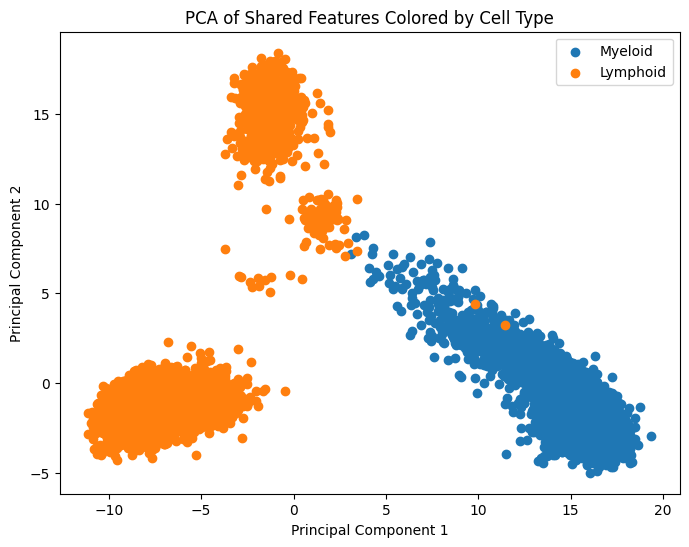

In [8]:
# prompt: generate a PCA visualization of the shared features across the train and test set and color based on cell type

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Combine the shared features from the train and test sets
train_shared_features = []
train_cell_types = []
for batch in train_loader:
    train_shared_features.extend(batch['shared'].numpy())
    train_cell_types.extend(batch['cell_type'])

test_shared_features = []
test_cell_types = []
for batch in test_loader:
    test_shared_features.extend(batch['shared'].numpy())
    test_cell_types.extend(batch['cell_type'])

combined_features = np.concatenate((train_shared_features, test_shared_features))
combined_cell_types = train_cell_types + test_cell_types

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components for visualization
pca_result = pca.fit_transform(combined_features)


# Create the PCA visualization
plt.figure(figsize=(8, 6))
for cell_type in set(combined_cell_types):
    indices = [i for i, x in enumerate(combined_cell_types) if x == cell_type]
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=cell_type)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Shared Features Colored by Cell Type")
plt.legend()
plt.show()

In [ ]:
# prompt: generate a PCA embedding of non shared features

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import json
import glob
import itertools
from PIL import Image
import pandas as pd
from google.colab import drive
from sklearn.decomposition import PCA

cudnn.benchmark = True
plt.ion()   # interactive mode

drive.mount('/content/drive')

# ... (rest of your code)

# Combine the non-shared features from the train and test sets
train_rna_features = []
train_cell_types_rna = []
for batch in train_loader:
    train_rna_features.extend(batch['rna'].numpy())
    train_cell_types_rna.extend(batch['cell_type'])

test_atac_features = []
test_cell_types_atac = []
for batch in test_loader:
    test_atac_features.extend(batch['atac'].numpy())
    test_cell_types_atac.extend(batch['cell_type'])

combined_rna_features = np.concatenate((train_rna_features,test_atac_features))
combined_cell_types_rna = train_cell_types_rna + test_cell_types_atac

# Apply PCA to the non-shared features
pca_rna = PCA(n_components=2)
pca_result_rna = pca_rna.fit_transform(combined_rna_features)

# Create the PCA visualization for non-shared features
plt.figure(figsize=(8, 6))
for cell_type in set(combined_cell_types_rna):
    indices = [i for i, x in enumerate(combined_cell_types_rna) if x == cell_type]
    plt.scatter(pca_result_rna[indices, 0], pca_result_rna[indices, 1], label=cell_type)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Non-Shared Features (RNA/ATAC) Colored by Cell Type")
plt.legend()
plt.show()

Mounted at /content/drive


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 788

In [7]:
import torch

def compute_jaccard_similarity(embeddings_omics1, embeddings_omics2, k=100):
    """
    Computes differentiable Jaccard similarity between nearest neighbors in two omics layers.

    Args:
        embeddings_omics1 (torch.Tensor): Embeddings for omics layer 1 (e.g., RNA).
        embeddings_omics2 (torch.Tensor): Embeddings for omics layer 2 (e.g., chromatin).
        k (int): Number of nearest neighbors to consider (default is 100).

    Returns:
        torch.Tensor: Mean Jaccard similarity across all cells.
    """
    num_cells_omics1 = embeddings_omics1.shape[0]
    num_cells_omics2 = embeddings_omics2.shape[0]

    # Combine embeddings
    combined_embeddings = torch.cat([embeddings_omics1, embeddings_omics2])
    print(combined_embeddings.shape)
    print(embeddings_omics1.shape)
    print(embeddings_omics2.shape)

    # Compute pairwise distances
    distances = torch.cdist(combined_embeddings, combined_embeddings)

    # Get top k nearest neighbors for each cell
    _, neighbors = torch.topk(distances, k=k, largest=False, dim=1)

    jaccard_similarities = []

    for i in range(num_cells_omics1 + num_cells_omics2):
        # Create binary tensors for set representation
        set_omics1 = torch.zeros(num_cells_omics1 + num_cells_omics2, device=embeddings_omics1.device)
        set_omics2 = torch.zeros(num_cells_omics1 + num_cells_omics2, device=embeddings_omics1.device)

        # Fill in the sets based on the neighbors
        set_omics1[neighbors[i]] = 1
        set_omics2[neighbors[i]] = 1

        # Adjust sets based on which omics layer the cell belongs to
        if i < num_cells_omics1:
            set_omics1[num_cells_omics1:] = 0
        else:
            set_omics2[:num_cells_omics1] = 0

        # Compute intersection and union
        intersection = torch.min(set_omics1, set_omics2).sum()
        union = torch.max(set_omics1, set_omics2).sum()

        # Compute Jaccard similarity
        jaccard_similarity = intersection / (union + 1e-8)  # Add small epsilon to avoid division by zero
        jaccard_similarities.append(jaccard_similarity)

    # Return the mean Jaccard similarity
    return torch.stack(jaccard_similarities).mean()

In [ ]:
import torch

def calculate_foscttm_loss(true_matches, distances):
    """
    Calculates the Fraction of Samples Closer Than the True Match (FOSCTTM) loss.

    Parameters:
        true_matches (torch.Tensor): Indices of true matches in the `distances` tensor for each query.
                                      Shape: (n_queries,)
        distances (torch.Tensor): Pairwise distance tensor of shape (n_queries, n_samples).

    Returns:
        torch.Tensor: The FOSCTTM loss value (lower is better).
    """
    n_queries = distances.shape[0]
    # Initialize a tensor of zeros with requires_grad=True
    # Use .clone() to create a new tensor that does not share storage with the original
    foscttm_values = torch.zeros(n_queries, device=distances.device, requires_grad=True).clone()

    for i in range(n_queries):
        true_match_index = true_matches[i]
        true_match_distance = distances[i, true_match_index]
        closer_count = torch.sum(distances[i] < true_match_distance)
        # Calculate the FOSCTTM value and detach it before assigning
        foscttm_value = closer_count.detach() / (distances.shape[1] - 1)
        foscttm_values[i] = foscttm_value # Assign the detached value

    # Calculate and return the mean FOSCTTM loss
    return foscttm_values.mean()

def loss_func(rna_embeddings, multi_embeddings):
    """
    Calculates the loss based on FOSCTTM.

    Parameters:
        rna_embeddings (torch.Tensor): Embeddings for RNA data.
        multi_embeddings (torch.Tensor): Embeddings for Multiome data.

    Returns:
        torch.Tensor: The FOSCTTM loss value.
    """
    # Calculate pairwise distances between embeddings
    distances = torch.cdist(rna_embeddings, multi_embeddings)

    # Get indices of true matches (assuming one-to-one correspondence)
    # You might need to modify this part based on your specific data structure
    true_matches = torch.arange(rna_embeddings.shape[0], device=rna_embeddings.device)

    # Calculate FOSCTTM loss
    loss = calculate_foscttm_loss(true_matches, distances)

    return loss

In [10]:
# prompt: set device to gpu

import torch

# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Setting device to GPU.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Setting device to CPU.")



GPU is available. Setting device to GPU.


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.3)  # Fix: dropout layer added correctly
        )
        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Assuming input features are normalized between 0 and 1
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = torch.clamp(self.fc_log_var(h), min=-20, max=20)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * torch.clamp(log_var, max=10))  # Clamping for numerical stability
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z)
        return recon_x, mu, log_var

    def get_logits(self, x):
        """ Returns the raw logits before the decoder layer. """
        # Passing through the encoder and the latent space layers
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_log_var(h)

def vae_loss_function(recon_x, x, mu, log_var):
    # Reconstruction loss (MSE loss)
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')

    # KL divergence loss
    kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - torch.exp(torch.clamp(log_var, max=10)))

    # Total VAE loss
    return recon_loss + kl_loss

def soft_nearest_neighbor_loss(embeddings, labels, temperature=0.1, num_neighbors=5):
    temperature = torch.clamp(torch.tensor(temperature), min=1e-3, max=10)
    similarities = torch.mm(embeddings, embeddings.t()) / temperature
    probs = F.softmax(similarities, dim=1)

    _, neighbors = similarities.topk(num_neighbors + 1, dim=1)
    neighbors = neighbors[:, 1:]

    neighbor_labels = labels[neighbors]
    labels_for_neighbors = labels.unsqueeze(1).expand_as(neighbor_labels)
    neighbor_probs = probs.gather(1, neighbors)

    mask = (neighbor_labels == labels_for_neighbors).float()
    masked_probs_sum = (neighbor_probs * mask).sum(dim=1) + 1e-8

    return -torch.log(masked_probs_sum).mean()


In [12]:
for batch in train_loader:
    rna_tensor = batch['rna']
    atac_tensor = batch['atac']
    shared_tensor = batch['shared']
    break
input_dim = rna_tensor.shape[1] + atac_tensor.shape[1] + shared_tensor.shape[1] # Example input dimension
hidden_dim = 6
latent_dim = 32
embedding_size = 2  # Replace with the actual number of cell types
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model instance and move to device
model = MLPVAE(input_dim, hidden_dim, latent_dim).to(device)
model = model.to(device)
# Hyperparameters
num_epochs = 10
learning_rate = 1e-4
jaccard_weight = 0  # Weight for Jaccard similarity in the loss function

Epoch [1/10], Loss: 2.0803
Epoch [2/10], Loss: 1.4127
Epoch [3/10], Loss: 1.1832
Epoch [4/10], Loss: 1.1074
Epoch [5/10], Loss: 1.0368
Epoch [6/10], Loss: 1.0276
Epoch [7/10], Loss: 0.9698
Epoch [8/10], Loss: 0.9817
Epoch [9/10], Loss: 0.9287
Epoch [10/10], Loss: 0.9591


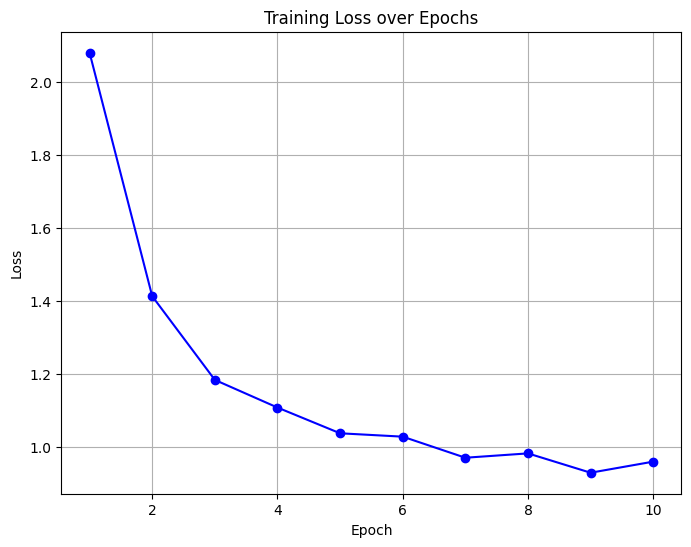

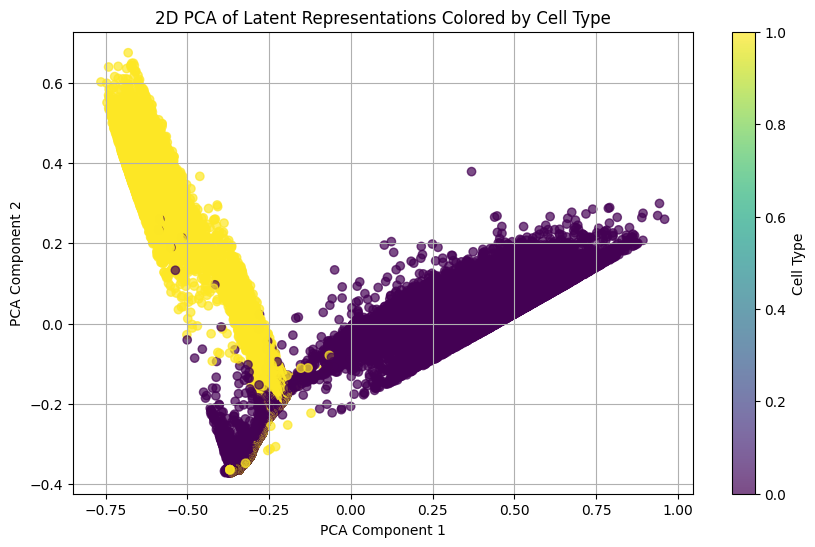

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder

# Initialize lists to store metrics and data
losses = []
latent_representations = []
all_cell_types = []

# Initialize optimizer and label encoder
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
label_encoder = LabelEncoder()

# Fit label encoder on all unique cell types
all_unique_cell_types = np.unique(train_dataset.cell_type)
label_encoder.fit(all_unique_cell_types)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        # Move tensors to device
        rna_tensor = batch['rna'].to(device)
        atac_tensor = batch['atac'].to(device)
        shared_tensor = batch['shared'].to(device)
        cell_types = batch['cell_type']

        # Encode cell types
        cell_types_encoded = label_encoder.transform(cell_types)
        cell_types_tensor = torch.tensor(cell_types_encoded, dtype=torch.long, device=device)

        # Concatenate input data
        input_data = torch.cat([rna_tensor, atac_tensor, shared_tensor], dim=1)

        # Forward pass
        recon_x, mu, log_var = model(input_data)

        # Compute losses
        vae_loss = vae_loss_function(recon_x, input_data, mu, log_var)
        s_nn_loss = soft_nearest_neighbor_loss(mu, cell_types_tensor, temperature=0.1, num_neighbors=5)
        loss = vae_loss + s_nn_loss

        # Check for NaN in loss
        if torch.isnan(loss):
            print("NaN detected in loss! Skipping this batch.")
            continue

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Store latent representations and cell types
        latent_representations.append(mu.cpu().detach().numpy())
        all_cell_types.append(cell_types_encoded)

        # Accumulate batch loss
        epoch_loss += loss.item()

    # Store average loss for this epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

# Combine all latent representations and cell types
latent_representations = np.vstack(latent_representations)
all_cell_types = np.concatenate(all_cell_types)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

# PCA visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_representations)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=all_cell_types, cmap='viridis', alpha=0.7)
plt.title('2D PCA of Latent Representations Colored by Cell Type')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cell Type')
plt.grid(True)
plt.show()

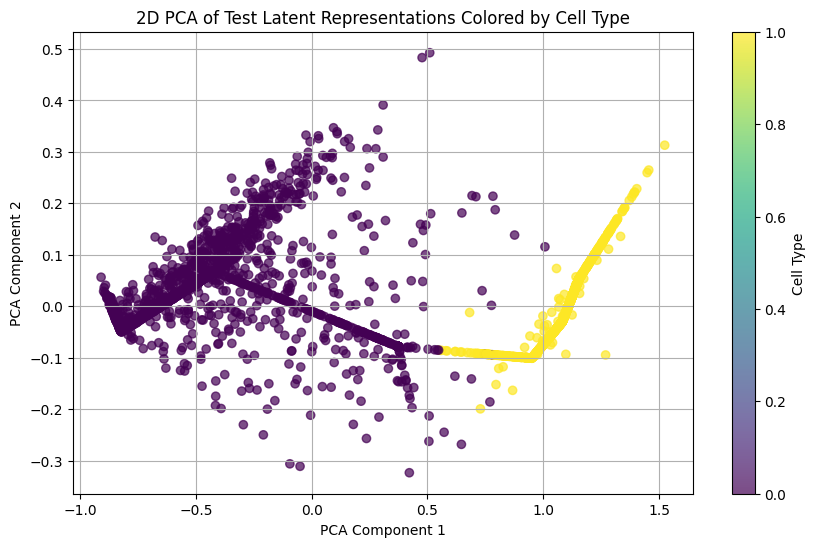

In [ ]:
# prompt: visualize the test results

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'all_latent_reps' and 'all_cell_types' are available from your training loop

# Apply PCA to the latent representations
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_latent_reps)

# Create the PCA visualization for the test set
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=all_cell_types, cmap='viridis', alpha=0.7)
plt.title('2D PCA of Test Latent Representations Colored by Cell Type')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cell Type')
plt.grid(True)
plt.show()

In [ ]:

def compute_knn_accuracy(train_logits, train_labels, test_logits, test_labels, k=5):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_logits, train_labels)
    predictions = knn.predict(test_logits)
    return accuracy_score(test_labels, predictions)

In [ ]:
# Initialize lists to store metrics and data
train_losses = []
test_losses = []
latent_representations = []
all_cell_types = []
logits_list = []  # List to store logits

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_train_loss = 0

    # Training phase
    for batch in train_loader:
        optimizer.zero_grad()

        # Move tensors to device
        rna_tensor = batch['rna'].to(device)
        atac_tensor = batch['atac'].to(device)
        shared_tensor = batch['shared'].to(device)
        cell_types = batch['cell_type']

        # Encode cell types
        cell_types_encoded = label_encoder.transform(cell_types)
        cell_types_tensor = torch.tensor(cell_types_encoded, dtype=torch.long, device=device)

        # Concatenate input data
        input_data = torch.cat([rna_tensor, atac_tensor, shared_tensor], dim=1)

        # Forward pass
        recon_x, mu, log_var = model(input_data)

        # Get logits from the model
        logits_mu, logits_log_var = model.get_logits(input_data)

        # Compute losses
        vae_loss = vae_loss_function(recon_x, input_data, mu, log_var)
        s_nn_loss = soft_nearest_neighbor_loss(logits_mu, cell_types_tensor, temperature=0.1, num_neighbors=5)
        loss = vae_loss + s_nn_loss

        # Check for NaN in loss
        if torch.isnan(loss):
            print("NaN detected in loss! Skipping this batch.")
            continue

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Store latent representations and cell types
        latent_representations.append(mu.cpu().detach().numpy())
        all_cell_types.append(cell_types_encoded)

        # Accumulate batch loss
        epoch_train_loss += loss.item()

    # Store average train loss for this epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Evaluation phase (on the test set)
    model.eval()  # Set model to evaluation mode
    epoch_test_loss = 0
    all_latent_reps = []
    all_test_cell_types = []
    all_logits = []  # List to store logits during evaluation

    with torch.no_grad():  # No need to track gradients during evaluation
        for batch in test_loader:
            # Move tensors to device
            rna_tensor = batch['rna'].to(device)
            atac_tensor = batch['atac'].to(device)
            shared_tensor = batch['shared'].to(device)
            cell_types = batch['cell_type']

            # Encode cell types using the same label encoder
            cell_types_encoded = label_encoder.transform(cell_types)
            cell_types_tensor = torch.tensor(cell_types_encoded, dtype=torch.long, device=device)

            # Prepare input data
            input_data = torch.cat([rna_tensor, atac_tensor, shared_tensor], dim=1)

            # Forward pass
            recon_x, mu, log_var = model(input_data)

            # Get logits from the model
            logits_mu, logits_log_var = model.get_logits(input_data)

            # Compute losses
            vae_loss = vae_loss_function(recon_x, input_data, mu, log_var)
            s_nn_loss = soft_nearest_neighbor_loss(logits_mu, cell_types_tensor, temperature=0.1, num_neighbors=5)
            loss = vae_loss + s_nn_loss
            epoch_test_loss += loss.item()

            # Store latent representations, logits, and true labels
            all_latent_reps.append(mu.cpu().detach().numpy())
            all_test_cell_types.extend(cell_types_encoded)  # Use extend to avoid nested lists
            all_logits.append(logits_mu.cpu().detach().numpy())  # Logits are the raw outputs from the model

        # Average test loss
        avg_test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}")

# Combine all latent representations and cell types for PCA and classification
latent_representations = np.vstack(latent_representations)
all_cell_types = np.concatenate(all_cell_types)

# Combine all logits (no need to apply softmax yet)
logits_list = np.vstack(all_logits)

# Return test labels and logits
test_labels = np.array(all_test_cell_types)

# Print shapes for verification
print(f"Test Labels shape: {test_labels.shape}")
print(f"Logits shape: {logits_list.shape}")


Epoch [1/10], Train Loss: 0.9725
Epoch [1/10], Test Loss: 1.6393
Epoch [2/10], Train Loss: 0.9410
Epoch [2/10], Test Loss: 1.6354
Epoch [3/10], Train Loss: 0.9453
Epoch [3/10], Test Loss: 1.6355
Epoch [4/10], Train Loss: 0.9139
Epoch [4/10], Test Loss: 1.6354
Epoch [5/10], Train Loss: 0.9229
Epoch [5/10], Test Loss: 1.6323
Epoch [6/10], Train Loss: 0.9170
Epoch [6/10], Test Loss: 1.6415
Epoch [7/10], Train Loss: 0.9091
Epoch [7/10], Test Loss: 1.6345
Epoch [8/10], Train Loss: 0.8955
Epoch [8/10], Test Loss: 1.6337
Epoch [9/10], Train Loss: 0.8570
Epoch [9/10], Test Loss: 1.6331
Epoch [10/10], Train Loss: 0.8956
Epoch [10/10], Test Loss: 1.6351
Test Labels shape: (4982,)
Logits shape: (4982, 32)


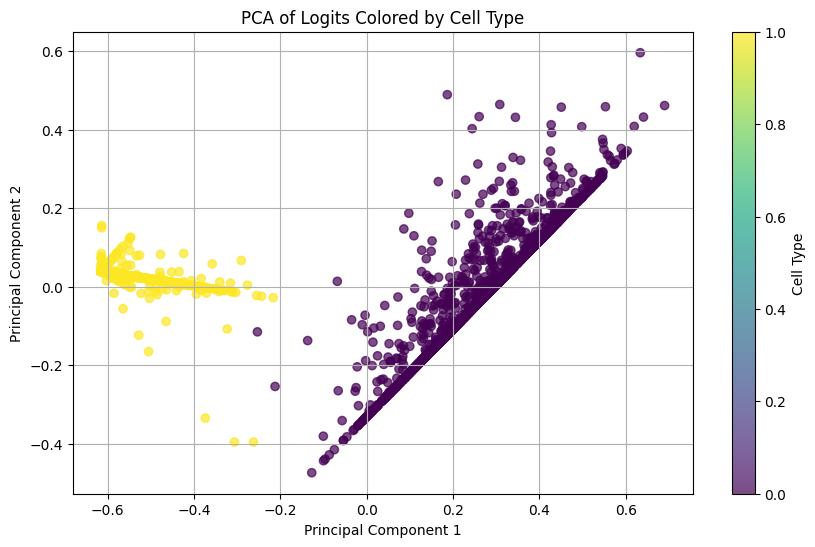

In [ ]:
# prompt: generate a PCA of the logits returned from get_logits

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'logits_list' and 'test_labels' are available from the previous code

# Apply PCA to the logits
pca = PCA(n_components=2)  # Reduce to 2 principal components for visualization
pca_result = pca.fit_transform(logits_list)

# Create the PCA visualization
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=test_labels, cmap='viridis', alpha=0.7)
plt.title('PCA of Logits Colored by Cell Type')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cell Type')
plt.grid(True)
plt.show()

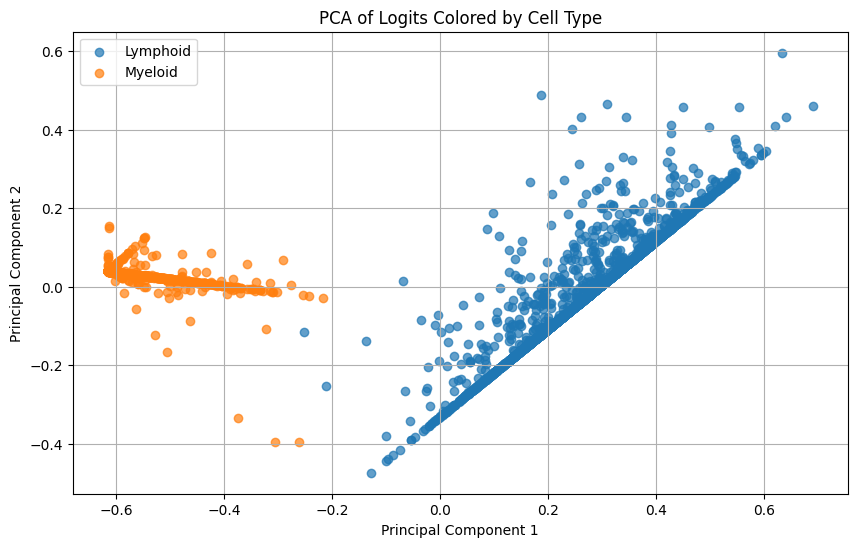

In [ ]:
# prompt: generate a PCA of logits and color them based on cell type dont use cmap_ label them as Lymphoid or Myeloid use matplotlib not seaborn

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'logits_list' and 'test_labels' are available from the previous code

# Apply PCA to the logits
pca = PCA(n_components=2)  # Reduce to 2 principal components for visualization
pca_result = pca.fit_transform(logits_list)

# Create a mapping for cell type labels (replace with your actual labels)
cell_type_mapping = {
    0: "Lymphoid",  # Example mapping for class 0
    1: "Myeloid"   # Example mapping for class 1
    # ... add other mappings as needed
}

# Map the numerical cell type labels to the new labels
mapped_labels = [cell_type_mapping.get(label, "Unknown") for label in test_labels]

# Create the PCA visualization with the specified colors and labels
plt.figure(figsize=(10, 6))

# Scatter plot with color mapping
for label_value, label_name in cell_type_mapping.items():
  indices = [i for i, label in enumerate(test_labels) if label == label_value]
  plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=label_name, alpha=0.7)

plt.title('PCA of Logits Colored by Cell Type')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()  # Add the legend to show the cell type labels
plt.grid(True)
plt.show()

In [ ]:
# prompt: evaluate the knn_accuracy of the embedding

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Assuming you have train_logits, train_labels, test_logits, and test_labels
# Replace these placeholders with your actual data

# Example usage (assuming mu is your embedding):
train_logits = latent_representations[:len(train_dataset)]
train_labels = all_cell_types[:len(train_dataset)]

# Evaluate the knn accuracy on the test set
test_logits = latent_representations[len(train_dataset):]
test_labels = all_cell_types[len(train_dataset):]


knn_accuracy = compute_knn_accuracy(train_logits, train_labels, test_logits, test_labels, k=5)
print(f"KNN accuracy on test set: {knn_accuracy}")

KNN accuracy on test set: 0.9966763514703293


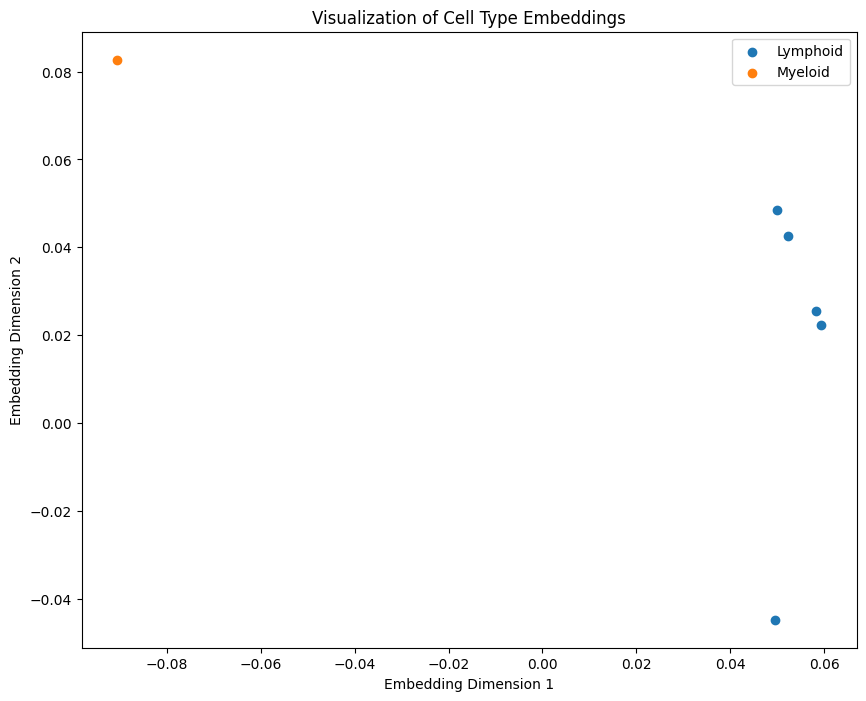

In [ ]:
# prompt: visualize the embedding

import matplotlib.pyplot as plt

# Assuming 'mu' contains the embeddings from the last batch of your training loop
# You'll need to collect embeddings from all batches if you want to visualize the entire dataset

# Get the embeddings and corresponding cell types from the last batch
embeddings = mu.cpu().detach().numpy() # Move embeddings to CPU and detach from computation graph
cell_types = np.array(cell_types) # Convert cell_types to a NumPy array

# Create the plot
plt.figure(figsize=(10, 8))
for cell_type in np.unique(cell_types):
    indices = np.where(cell_types == cell_type)
    plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=str(cell_type))

plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")  # Adjust based on your embedding dimensions
plt.title("Visualization of Cell Type Embeddings")
plt.legend()
plt.show()

In [ ]:
# prompt: Print total number of parameters in model

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 23,314 trainable parameters


We are training on the multimodal data, test on atac_seq, need to add loss function

Epoch [1/10], Train Loss: 0.8439
Epoch [1/10], Test Loss: 1.6732
Epoch [2/10], Train Loss: 0.8544
Epoch [2/10], Test Loss: 1.6719
Epoch [3/10], Train Loss: 0.8581
Epoch [3/10], Test Loss: 1.6626
Epoch [4/10], Train Loss: 0.8819
Epoch [4/10], Test Loss: 1.6733
Epoch [5/10], Train Loss: 0.8328
Epoch [5/10], Test Loss: 1.6754
Epoch [6/10], Train Loss: 0.8624
Epoch [6/10], Test Loss: 1.6599
Epoch [7/10], Train Loss: 0.8632
Epoch [7/10], Test Loss: 1.6666
Epoch [8/10], Train Loss: 0.8586
Epoch [8/10], Test Loss: 1.6610
Epoch [9/10], Train Loss: 0.9090
Epoch [9/10], Test Loss: 1.6656
Epoch [10/10], Train Loss: 0.8447
Epoch [10/10], Test Loss: 1.6633


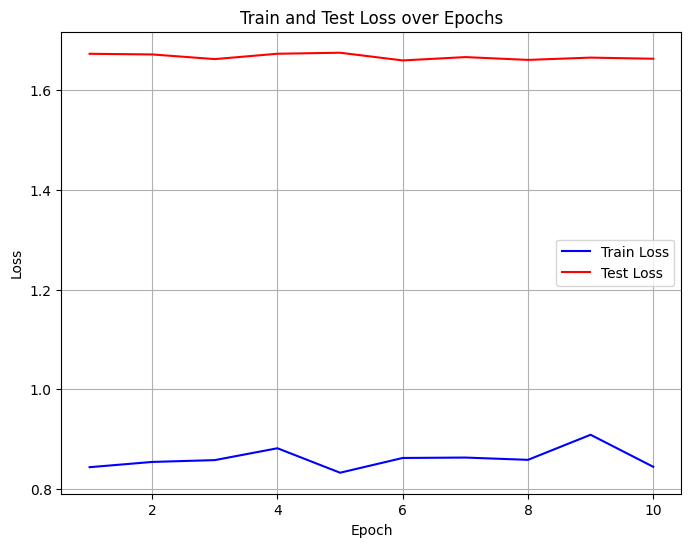

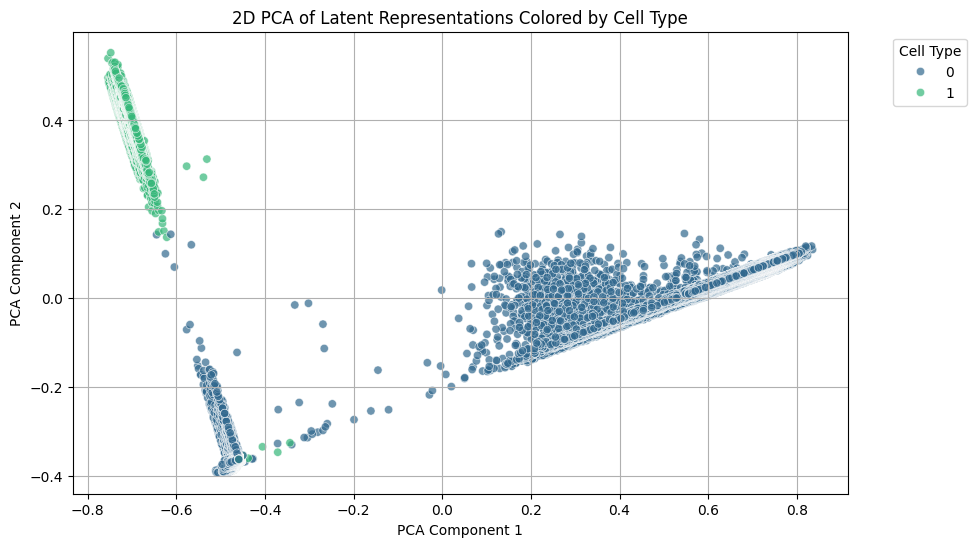

Test Accuracy (k-NN on Latent Space): 0.9253
Jaccard Similarity: 0.8613


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize lists to store metrics and data
train_losses = []
test_losses = []
latent_representations = []
all_cell_types = []

# Initialize optimizer and label encoder
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
label_encoder = LabelEncoder()

# Fit label encoder on all unique cell types
all_unique_cell_types = np.unique(train_dataset.cell_type)
label_encoder.fit(all_unique_cell_types)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_train_loss = 0

    # Training phase
    for batch in train_loader:
        optimizer.zero_grad()

        # Move tensors to device
        rna_tensor = batch['rna'].to(device)
        atac_tensor = batch['atac'].to(device)
        shared_tensor = batch['shared'].to(device)
        cell_types = batch['cell_type']

        # Encode cell types
        cell_types_encoded = label_encoder.transform(cell_types)
        cell_types_tensor = torch.tensor(cell_types_encoded, dtype=torch.long, device=device)

        # Concatenate input data
        input_data = torch.cat([rna_tensor, atac_tensor, shared_tensor], dim=1)

        # Forward pass
        recon_x, mu, log_var = model(input_data)

        # Compute losses
        vae_loss = vae_loss_function(recon_x, input_data, mu, log_var)
        s_nn_loss = soft_nearest_neighbor_loss(mu, cell_types_tensor, temperature=0.1, num_neighbors=5)
        loss = vae_loss + s_nn_loss

        # Check for NaN in loss
        if torch.isnan(loss):
            print("NaN detected in loss! Skipping this batch.")
            continue

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Store latent representations and cell types
        latent_representations.append(mu.cpu().detach().numpy())
        all_cell_types.append(cell_types_encoded)

        # Accumulate batch loss
        epoch_train_loss += loss.item()

    # Store average train loss for this epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Evaluation phase (on the test set)
    model.eval()  # Set model to evaluation mode
    epoch_test_loss = 0
    all_latent_reps = []
    all_test_cell_types = []

    with torch.no_grad():  # No need to track gradients during evaluation
        for batch in test_loader:
            # Move tensors to device
            rna_tensor = batch['rna'].to(device)
            atac_tensor = batch['atac'].to(device)
            shared_tensor = batch['shared'].to(device)
            cell_types = batch['cell_type']

            # Encode cell types using the same label encoder
            cell_types_encoded = label_encoder.transform(cell_types)
            cell_types_tensor = torch.tensor(cell_types_encoded, dtype=torch.long, device=device)

            # Prepare input data
            input_data = torch.cat([rna_tensor, atac_tensor, shared_tensor], dim=1)

            # Forward pass
            recon_x, mu, log_var = model(input_data)

            # Compute losses
            vae_loss = vae_loss_function(recon_x, input_data, mu, log_var)
            s_nn_loss = soft_nearest_neighbor_loss(mu, cell_types_tensor, temperature=0.1, num_neighbors=5)
            loss = vae_loss + s_nn_loss
            epoch_test_loss += loss.item()

            # Store latent representations and true labels
            all_latent_reps.append(mu.cpu().detach().numpy())
            all_test_cell_types.extend(cell_types_encoded)  # Use extend to avoid nested lists

        # Average test loss
        avg_test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}")

# Combine all latent representations and cell types for PCA and classification
latent_representations = np.vstack(latent_representations)
all_cell_types = np.concatenate(all_cell_types)

# Plot train and test losses using Seaborn
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='b')  # Removed marker='o'
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='r')  # Removed marker='o'
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt


# PCA visualization using Seaborn
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_representations)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=all_cell_types, palette='viridis', alpha=0.7)
plt.title('2D PCA of Latent Representations Colored by Cell Type')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Optional: Classification on latent space (e.g., k-NN)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(latent_representations, all_cell_types)  # Use latent_representations for fitting
predicted_labels = knn.predict(latent_representations)

# Calculate accuracy
accuracy = accuracy_score(all_cell_types, predicted_labels)
print(f"Test Accuracy (k-NN on Latent Space): {accuracy:.4f}")

#Calculate jaccard similarity
from sklearn.metrics import jaccard_score
jaccard_sim = jaccard_score(all_cell_types, predicted_labels, average='weighted')
print(f"Jaccard Similarity: {jaccard_sim:.4f}")
